In [294]:
           
    
                     ###################### Mohamed YOULA ########################### 
    
  # In this exercise I use convolutional neural networks to train my model on three types of data that I will build from the #
         # initial dataset. Then I will select the best model among the registered model. #
    
    

In [254]:
                        ############   Packages and data importation  ############ 

In [255]:
                     
 
import os
from statistics import mean

import math
from statistics import mean
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform


import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

folder_images1 = "C:/Users/cash/Desktop/test_deep_learning/Test/fields"
folder_images2 = "C:/Users/cash/Desktop/test_deep_learning/Test/roads"

my_models_dir='C:/Users/cash/Desktop/test_deep_learning/models_set'

In [256]:
      ###########################################################################################################
      ###########################################################################################################
      #                                         DATA                                                            # 
      ###########################################################################################################
      ###########################################################################################################

In [257]:
                              
                                #  Here we have a functions  #            

def read_images(folder_images,label=0):
   # this function allows you to build a dataset by assigning a label(1==road or 0== fiels) to each image# 
   x=[] 
   y=[]
   for dirpath, _, filenames in os.walk(folder_images):
       for path_image in filenames:
           image_path = os.path.abspath(os.path.join(dirpath, path_image)) # image path
           image=io.imread(f'{image_path}') # image 
           x.append(image) # list of images 
           y.append(label) # lis of labels
   return x,y     


In [258]:
               # Here we build our main dataset using the two previous functions #
    
D1=read_images(folder_images1,1)
D2=read_images(folder_images2,0)  
x=D1[0]+D2[0]
y=D1[1]+D2[1]
D=np.column_stack((x,y))
p = np.random.permutation(D.shape[0])
D=D[p]

C:\Users\cash\anaconda3\envs\tf\lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


In [259]:
D.shape

(90, 2)

In [260]:
       
        # Construction of the training set (80% of the data) and of the test set (20% of the data) #
    
X=D[:,0] 
Y=D[:,1]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [261]:
                         # Few statistics about train dataset #

In [262]:
           # This function retrieves the length and width of images from our dataset.#
def statist(X):
    L=[]
    l=[]
    for image in X:
        (x,y,z)=image.shape
        L.append(x)
        l.append(y)
    return L,l
L,l=statist(X) 
nb_pixel_im=[L[n]*l[n] for n in range(len(l))] # list of products of length and width

In [263]:
print("maximum length                          :",max(L))
print("minimum length                          :",min(L))

print("maximum widths                          :",max(l))
print("minimum widths                          :",min(l))

print("The average length of the images        :",mean(L))
print("The average of the widths of the images :",mean(l))

maximum length                          : 275
minimum length                          : 118
maximum widths                          : 426
minimum widths                          : 183
The average length of the images        : 177.16666666666666
The average of the widths of the images : 287.6666666666667


Text(0.5, 1.0, 'Histogramme')

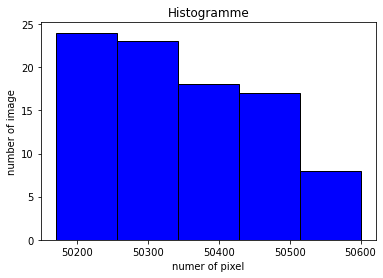

In [264]:
plt.hist(nb_pixel_im,bins = 5, color = 'blue',edgecolor = 'black')
plt.xlabel('numer of pixel')
plt.ylabel('number of image')
plt.title('Histogramme')

In [265]:
               # The statistics an the figure above shows that all the images are not the same size (in function number of pixels)#
      # We must therefore reduce them to the same size so that they are all compatible with the input layer of the same neuron network.#

In [266]:
                             ####### Transformation of the initial dataset ######

In [267]:
#This function allows us to vary the color level of the images. It also allows us to also modify the size of the images #

def images_enhancement(images, width=25, height=25, mode='RGB'):
   
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))     
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)           
                 
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.          
            
        # ---- Add image in list of list
        out.append(img)
    
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out


In [268]:


# Data for RGB (original data)
x_train_RGB=images_enhancement(x_train, width=118, height=118, mode='RGB')
x_test_RGB=images_enhancement(x_test, width=118, height=118, mode='RGB')

# Data for Grayscale
x_train_L=images_enhancement(x_train, width=118, height=118, mode='L')
x_test_L=images_enhancement(x_test, width=118, height=118, mode='L') 

# Data for Grayscale / Local Histogram Equalization
x_train_L_LHE=images_enhancement(x_train, width=118, height=118, mode='L-LHE')
x_test_L_LHE=images_enhancement(x_test, width=118, height=118, mode='L-LHE') 



In [269]:
print("x_train_RGB shape : ",x_train_RGB.shape)
print("y_train     shape : ",y_train.shape)
print("x_test_RGB  shape : ",x_test_RGB.shape)
print("y_test      shape : ",y_test.shape)

x_train_RGB shape :  (72, 118, 118, 3)
y_train     shape :  (72,)
x_test_RGB  shape :  (18, 118, 118, 3)
y_test      shape :  (18,)


In [292]:
       #  This function plot eache image with it corresponding label in or data   #

def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                y_pred=None):
    """    
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)        
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+0.35)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = 'binary', interpolation='lanczos')
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(1)
        axs.spines['left'].set_alpha(1)
        axs.spines['top'].set_alpha(1)
        axs.spines['bottom'].set_alpha(1)
        axs.set_yticks([])
        axs.set_xticks([])
        axs.set_xlabel(y[i],fontsize=20)
               
    plt.show()

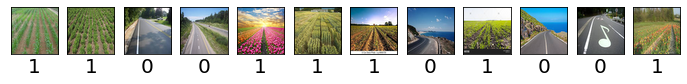

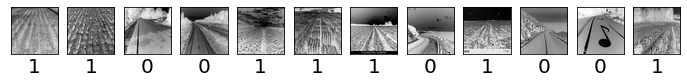

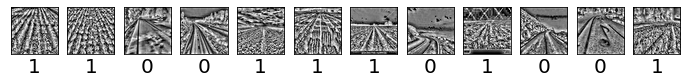

In [293]:
plot_images(x_train_RGB,  y_train, range(12), columns=12, x_size=1, y_size=1)

plot_images(x_train_L,  y_train, range(12), columns=12, x_size=1, y_size=1)

plot_images(x_train_L_LHE,  y_train, range(12), columns=12, x_size=1, y_size=1)

In [149]:
      ###########################################################################################################
      ###########################################################################################################
      #                                           MODEL                                                         # 
      ###########################################################################################################
      ###########################################################################################################  

In [170]:
# In this sequentil model the kernel size is 3x3

def get_model(lx,ly,lz):
    model = keras.models.Sequential() # for sequentil model
    
    # Here we build 10 2D convolution layers
    model.add( keras.layers.Conv2D(10, (3,3),   activation='relu', input_shape=(lx,ly,lz))) # the input layer should match the shape of the images
    model.add( keras.layers.MaxPooling2D((2, 2))) # pour sélectionner la valeur maximale des pixels dans une fenêtre 2x2
    model.add( keras.layers.Dropout(0.5)) # To select or not certain neurons with probability 0.5 when training the model. 
    
    #Here we build 25 2D convolution layers
    model.add( keras.layers.Conv2D(25, (3, 3), activation='relu')) # we use the 'relu' activation function to set certain to 0
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))
   
    #Here we build 25 2D convolution layers
    model.add( keras.layers.Conv2D(25, (3, 3), activation='relu')) 
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    #Here we build 25 2D convolution layers
    model.add( keras.layers.Conv2D(25, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))
    
    # Here we flatten our last convolution layers, then we connect them to 100 neurons
    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(100, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(1, activation='sigmoid'))# the last layer contains a single neuron whose activation function
                                                           #is the sigmoid function, because we do the binary classification
    return model


In [ ]:
               
    ##################### Training of our model on the first dataset (RGB) ################################
          

In [171]:
(n,lx,ly,lz) = x_train_RGB.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (118, 118, 3)


In [172]:
model0 = get_model(lx,ly,lz)

model0.summary()

model0.compile(optimizer = 'adam', # stochastic gradient for updating parameters during backpropagation
              loss      = 'binary_crossentropy', # loss function for binary classification, during model training
              metrics   = ['accuracy']) # to measure the quality of the model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 116, 116, 10)      280       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 58, 58, 10)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 56, 56, 25)        2275      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 28, 28, 25)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 28, 28, 25)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 26, 26, 25)      

In [173]:
#y_train and y_test had boolean values. So i convert them all to np.float32.
y_train = np.asarray(y_train).astype(np.float32) 
y_test = np.asarray(y_test).astype(np.float32)

# Model training
history = model0.fit(  x_train_RGB, y_train,
                      batch_size      = 55, # number of examples to use for updating parameters during an epoch
                      epochs          = 100, # number of epoch
                      verbose         = 1,
                      validation_data = (x_test_RGB, y_test))

model0.save(f'{my_models_dir}/last-model_RGB.h5') # save the last model

Epoch 1/100
2/2 [==============================] - 12s 3s/step - loss: 1.4969 - accuracy: 0.3750 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 0.9129 - accuracy: 0.5139 - val_loss: 0.6930 - val_accuracy: 0.7222
Epoch 3/100
2/2 [==============================] - 3s 1s/step - loss: 0.9261 - accuracy: 0.4583 - val_loss: 0.6928 - val_accuracy: 0.7222
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.7490 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5556
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 0.8032 - accuracy: 0.3611 - val_loss: 0.6940 - val_accuracy: 0.4444
Epoch 6/100
2/2 [==============================] - 6s 1s/step - loss: 0.6827 - accuracy: 0.5556 - val_loss: 0.6938 - val_accuracy: 0.4444
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 0.6818 - accuracy: 0.6528 - val_loss: 0.6935 - val_accuracy: 0.4444
Epoch 8/100
2/2 [================

In [174]:
 ##################### Training of our model on the second dataset (L) ################################

In [175]:
(n1,lx1,ly1,lz1) = x_train_L.shape
print("Images of the dataset have this folowing shape : ",(n1,lx1,ly1,lz1))

Images of the dataset have this folowing shape :  (72, 118, 118, 1)


In [176]:
model1 = get_model(lx1,ly1,lz1)

model1.summary()

model1.compile(optimizer = 'adam',
              loss      = 'binary_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 116, 116, 10)      100       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 58, 58, 10)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 56, 56, 25)        2275      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 28, 28, 25)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 28, 28, 25)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 26, 26, 25)      

In [177]:
history = model1.fit(  x_train_L, y_train,
                      batch_size      = 55,
                      epochs          = 100,
                      verbose         = 1,
                      validation_data = (x_test_L, y_test))

model1.save(f'{my_models_dir}/last-model_L.h5')# Save the model

Epoch 1/100
2/2 [==============================] - 13s 3s/step - loss: 0.8856 - accuracy: 0.4306 - val_loss: 0.6977 - val_accuracy: 0.3889
Epoch 2/100
2/2 [==============================] - 3s 974ms/step - loss: 0.8377 - accuracy: 0.4444 - val_loss: 0.6944 - val_accuracy: 0.4444
Epoch 3/100
2/2 [==============================] - 3s 977ms/step - loss: 0.8005 - accuracy: 0.4583 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 6s 2s/step - loss: 0.7039 - accuracy: 0.5278 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 4s 1s/step - loss: 0.7177 - accuracy: 0.5556 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 3s 975ms/step - loss: 0.7254 - accuracy: 0.4306 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 0.7272 - accuracy: 0.5278 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 8/100
2/2 [=======

In [178]:
  ##################### Training of our model on the third dataset (L_LHE) ################################

In [179]:
(n2,lx2,ly2,lz2) = x_train_L_LHE.shape
print("Images of the dataset have this folowing shape : ",(n2,lx2,ly2,lz2))

Images of the dataset have this folowing shape :  (72, 118, 118, 1)


In [180]:
model2 = get_model(lx2,ly2,lz2)

model2.summary()

model2.compile(optimizer = 'adam',
              loss      = 'binary_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 116, 116, 10)      100       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 58, 58, 10)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 56, 56, 25)        2275      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 28, 28, 25)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 28, 28, 25)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 26, 26, 25)      

In [181]:
history = model2.fit(  x_train_L_LHE, y_train,
                      batch_size      = 55,
                      epochs          = 100,
                      verbose         = 1,
                      validation_data = (x_test_L_LHE, y_test))

model2.save(f'{my_models_dir}/last-model_L_LHE.h5') # Save the model

Epoch 1/100
2/2 [==============================] - 19s 10s/step - loss: 0.7802 - accuracy: 0.4861 - val_loss: 0.6947 - val_accuracy: 0.4444
Epoch 2/100
2/2 [==============================] - 16s 2s/step - loss: 0.7300 - accuracy: 0.5139 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 4s 1s/step - loss: 0.6930 - accuracy: 0.5694 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.7263 - accuracy: 0.4861 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 3s 1s/step - loss: 0.6950 - accuracy: 0.5833 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 4s 2s/step - loss: 0.7234 - accuracy: 0.4444 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 5s 1s/step - loss: 0.6984 - accuracy: 0.5556 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 8/100
2/2 [==============

In [182]:
        ###################################################################################################
        ###################################################################################################
        #                                     EVALUATE MODEL                                              #
        ###################################################################################################        

In [183]:
                                        # Restore the best models #

#Best model on RGB dataset:  
loaded_model_RGB = tf.keras.models.load_model(f'{my_models_dir}/last-model_RGB.h5')

#Best model on L dataset: 
loaded_model_L = tf.keras.models.load_model(f'{my_models_dir}/last-model_L.h5')

#Best model on L_LHE dataset: 
loaded_model_L_LHE = tf.keras.models.load_model(f'{my_models_dir}/last-model_L_LHE.h5')

In [184]:
                                 # Selet the best model #
score0=loaded_model_RGB.evaluate(x_test_RGB, y_test, verbose=0)
score1=loaded_model_L.evaluate(x_test_L, y_test, verbose=0)
score2=loaded_model_L_LHE.evaluate(x_test_L_LHE, y_test, verbose=0)

Models=['loaded_model_RGB {:5.4f}','loaded_model_L','loaded_model_L_LHE']
Loss=[score0[0],score1[0],score2[0]]
i=Loss.index(min(Loss))
print('                                                                      ')

print('                 RGB     L       L_LHE')
print('Test loss      : {:5.4f}  {:5.4f}  {:5.4f}'.format(score0[0],score1[0],score2[0]))
print('Test accuracy  : {:5.4f}  {:5.4f}  {:5.4f}'.format(score0[1],score1[1],score2[1]))
print ('----------------------------------------')

print('The best model is "{}". It loss = {:5.4f}'.format(Models[i],Loss[i]))


                                                                      
                 RGB     L       L_LHE
Test loss      : 0.6318  0.5255  0.4237
Test accuracy  : 0.6667  0.8333  0.8333
----------------------------------------
The best model is "loaded_model_L_LHE". It loss = 0.4237


In [295]:
# We can also perform other tasks such as increasing data to have more data in order to improve the performance of or model.

In [296]:
                         ###### thank you! ####